11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
train data: Xtrain: (60000, 784), Ytrain: (60000,)
test data: Xtest: (10000, 784), Ytest: (10000,)
range X: [0.000, 1.000]
labels: [0 1 2 3 4 5 6 7 8 9]
epoch: 0
j / n_batches: 0 / 600 cost: 2.2937865 error: 0.83
j / n_batches: 100 / 600 cost: 2.3098676 error: 0.86
j / n_batches: 200 / 600 cost: 2.3106108 error: 0.86
j / n_batches: 300 / 600 cost: 2.2987945 error: 0.88
j / n_batches: 400 / 600 cost: 2.3126805 error: 0.91
j / n_batches: 500 / 600 cost: 2.3112657 error: 0.96
epoch: 1
j / n_batches: 0 / 600 cost: 2.2950616 error: 0.89
j / n_batches: 100 / 600 cost: 2.303129 error: 0.88
j / n_batches: 200 / 600 cost: 2.3118157 error: 0.92
j / n_batches: 300 / 600 cost: 2.3111677 error: 0.91
j / n_batches: 400 / 600 cost: 2.2918522 error: 0.92
j / n_batches: 500 / 600 cost: 2.2993646 error: 0.84
epoch: 2
j / n_batches: 0 / 600 cost: 2.3017702 error: 0.89
j / n_batches: 100 / 600 cost: 2.305801 error: 0.89
j / n_batches: 200 / 600 cost: 2.31

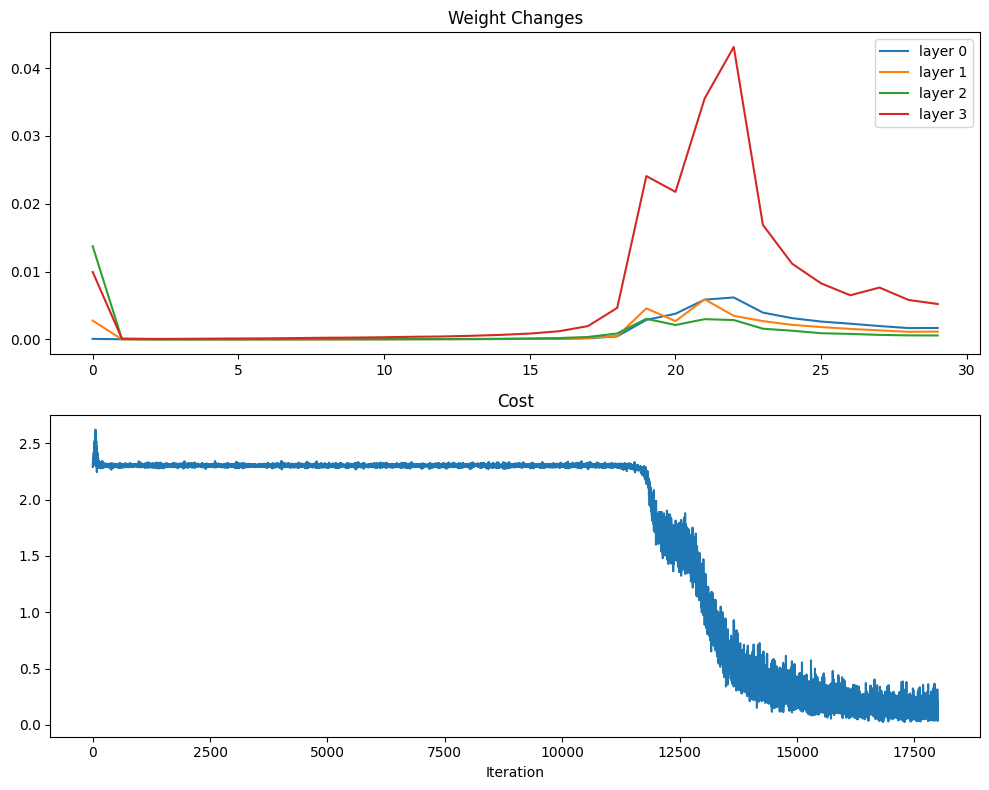

Error on test dataset: 0.0427


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist

def getKerasMNIST():

    (Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

    Xtrain = Xtrain.reshape(Xtrain.shape[0], 784)
    Xtest = Xtest.reshape(Xtest.shape[0], 784)

    Xtrain = Xtrain.astype(np.float32) / 255.0
    Xtest = Xtest.astype(np.float32) / 255.0

    print(f"train data: Xtrain: {Xtrain.shape}, Ytrain: {Ytrain.shape}")
    print(f"test data: Xtest: {Xtest.shape}, Ytest: {Ytest.shape}")
    print(f"range X: [{Xtrain.min():.3f}, {Xtrain.max():.3f}]")
    print(f"labels: {np.unique(Ytrain)}")

    return Xtrain, Ytrain, Xtest, Ytest

def error_rate(p, t):
    return np.mean(p != t)

def init_weights(shape):
    return tf.Variable(tf.random.normal(shape, stddev=0.01))

class HiddenLayer(object):
    def __init__(self, D, M):
        W = init_weights((D, M))
        b = tf.Variable(tf.zeros(M))
        self.W = W
        self.b = b
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.b)

class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=0.01, mu=0.99, epochs=30, batch_sz=100):
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        mi = D

        for mo in self.hidden_layer_sizes:
            h = HiddenLayer(mi, mo)
            self.hidden_layers.append(h)
            mi = mo

        W = init_weights((mi, K))
        b = tf.Variable(tf.zeros(K))
        self.W = W
        self.b = b
        self.params = [self.W, self.b]
        self.allWs = []

        for h in self.hidden_layers:
            self.params += h.params
            self.allWs.append(h.W)
        self.allWs.append(self.W)

        self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=mu)

        def compute_loss(X_batch, Y_batch):
            pY = self.forward(X_batch)
            loss = tf.reduce_mean(-tf.math.log(tf.gather_nd(pY,
                                                          tf.stack([tf.range(tf.shape(pY)[0]),
                                                                   tf.cast(Y_batch, tf.int32)], axis=1))))
            return loss

        @tf.function
        def train_step(X_batch, Y_batch):
            with tf.GradientTape() as tape:
                loss = compute_loss(X_batch, Y_batch)
            grads = tape.gradient(loss, self.params)
            self.optimizer.apply_gradients(zip(grads, self.params))
            return loss

        n_batches = N // batch_sz
        costs = []
        lastWs = [W.numpy() for W in self.allWs]
        W_changes = []

        for i in range(epochs):
            print("epoch:", i)
            X_shuffled, Y_shuffled = shuffle(X, Y)

            for j in range(n_batches):
                start_idx = j * batch_sz
                end_idx = start_idx + batch_sz
                X_batch = X_shuffled[start_idx:end_idx]
                Y_batch = Y_shuffled[start_idx:end_idx]

                X_batch_tf = tf.convert_to_tensor(X_batch, dtype=tf.float32)
                Y_batch_tf = tf.convert_to_tensor(Y_batch, dtype=tf.int32)

                loss = train_step(X_batch_tf, Y_batch_tf)
                c = loss.numpy()

                pY_batch = self.forward(X_batch_tf)
                p = tf.argmax(pY_batch, axis=1).numpy()

                if j % 100 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c, "error:", error_rate(p, Y_batch))
                costs.append(c)

            current_Ws = [W.numpy() for W in self.allWs]
            W_change = [np.abs(current_W - lastW).mean() for current_W, lastW in zip(current_Ws, lastWs)]
            W_changes.append(W_change)
            lastWs = current_Ws

        W_changes = np.array(W_changes)
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 1, 1)
        for i in range(W_changes.shape[1]):
            plt.plot(W_changes[:, i], label=f'layer {i}')
        plt.legend()
        plt.title('Weight Changes')

        plt.subplot(2, 1, 2)
        plt.plot(costs)
        plt.title('Cost')
        plt.xlabel('Iteration')

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        if not hasattr(X, 'numpy'):
            X = tf.convert_to_tensor(X, dtype=tf.float32)
        return tf.argmax(self.forward(X), axis=1).numpy()

    def forward(self, X):
        if not hasattr(X, 'numpy'):
            X = tf.convert_to_tensor(X, dtype=tf.float32)

        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        logits = tf.matmul(Z, self.W) + self.b
        Y = tf.nn.softmax(logits)
        return Y

if __name__ == "__main__":
    Xtrain, Ytrain, Xtest, Ytest = getKerasMNIST()
    dnn = ANN([1000, 750, 500])
    dnn.fit(Xtrain, Ytrain)

    predictions = dnn.predict(Xtest)
    test_error = error_rate(predictions, Ytest)
    print(f"Error on test dataset: {test_error:.4f}")